In [1]:
# extract tabular data from xlsx files & data preprocessing

import pandas as pd

file_path = 'IF.xlsx'

full_data = pd.read_excel(file_path, sheet_name='Sheet1')
full_data['date'] = pd.to_datetime(full_data['date'], format='%Y-%m-%d')
full_data = full_data.sort_values(by='date')

print(full_data.head())

   Unnamed: 0     code       date         high         open          low  \
0           0  IF.STAR 2014-12-31  3629.344971  3520.114990  3513.116943   
1           1  IF.STAR 2015-01-05  3808.710449  3645.882080  3624.120117   
2           2  IF.STAR 2015-01-06  3751.840088  3704.093262  3656.368408   
3           3  IF.STAR 2015-01-07  3728.693848  3705.989502  3662.371094   
4           4  IF.STAR 2015-01-08  3731.784180  3725.778076  3605.295410   

         close      vol      oi  
0  3626.701660  1526454  215437  
1  3711.989746  1500643  237221  
2  3701.137695  1737699  236054  
3  3711.765869  1475006  231591  
4  3610.805664  1807466  229779  


In [2]:
# calculating factors

import numpy as np

def feature_eng(df):

    # MA
    df['MA5'] = df['close'].rolling(window=5).mean()
    df['MA10'] = df['close'].rolling(window=10).mean()
    df['MA30'] = df['close'].rolling(window=30).mean()

    # RSI
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    df['RSI'] = 100 - (100 / (1 + RS))

    # MACD
    df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Volatility
    df['Volatility5'] = df['close'].pct_change().rolling(window=5).std() * np.sqrt(5)

    # more factors can be added there
    # ....

    # gen (-1, 0, 1) for (-1%, -1% ~ 1%, 1%) close price change
    # df['tomorrow_pct_change'] = df['close'].pct_change().shift(-1)

    # df.loc[df['tomorrow_pct_change'] < -0.02, 'label'] = -1
    # df.loc[df['tomorrow_pct_change'] > 0.02,'label'] = 1
    # df['label'] = df['label'].fillna(0)

    # 假设 'close' 是收盘价列
    df['5d_future_close'] = df['close'].shift(-5)  # 五日后的收盘价
    df['5d_pct_change'] = (df['5d_future_close'] - df['close']) / df['close']
    df.loc[df['5d_pct_change'] > 0.05, 'label'] = 3
    df.loc[(df['5d_pct_change'] > 0.03) & (df['5d_pct_change'] <= 0.05), 'label'] = 2
    df.loc[(df['5d_pct_change'] > 0.01) & (df['5d_pct_change'] <= 0.03), 'label'] = 1
    df.loc[(df['5d_pct_change'] >= -0.01) & (df['5d_pct_change'] <= 0.01), 'label'] = 0
    df.loc[(df['5d_pct_change'] < -0.01) & (df['5d_pct_change'] >= -0.03), 'label'] = -1
    df.loc[(df['5d_pct_change'] < -0.03) & (df['5d_pct_change'] >= -0.05), 'label'] = -2
    df.loc[df['5d_pct_change'] < -0.05, 'label'] = -3

    # drop NaN
    df.dropna(inplace=True)
    




feature_eng(full_data)

train_data = full_data[full_data['date'] <= '2022-12-31']
test_data = full_data[full_data['date'] > '2022-12-31']
test_data.loc[test_data.index, 'label'] = 0

print(f"Training set size: {train_data.shape[0]}")
print(f"Test set size: {test_data.shape[0]}")

print(train_data.head())


Training set size: 1919
Test set size: 283
    Unnamed: 0     code       date         high         open          low  \
29          29  IF.STAR 2015-02-12  3508.032715  3491.431641  3456.929932   
30          30  IF.STAR 2015-02-13  3573.802246  3499.444580  3489.484619   
31          31  IF.STAR 2015-02-16  3558.757812  3515.193604  3509.152344   
32          32  IF.STAR 2015-02-17  3594.882080  3560.825928  3556.203369   
33          33  IF.STAR 2015-02-25  3584.598633  3581.411865  3486.353516   

          close      vol      oi          MA5  ...         MA30        RSI  \
29  3494.216553  1083933  248680  3447.245117  ...  3544.709351  38.156086   
30  3505.636719  1382845  239701  3474.009912  ...  3540.673853  36.304180   
31  3553.135742   882121  240428  3502.814893  ...  3535.378719  45.428206   
32  3569.532227   872386  238206  3521.868945  ...  3530.991870  51.732429   
33  3503.386963   966332  222986  3525.181641  ...  3524.045907  48.782064   

          EMA12        EM

Text(2023-01-03 00:00:00, 6000, 'Test')

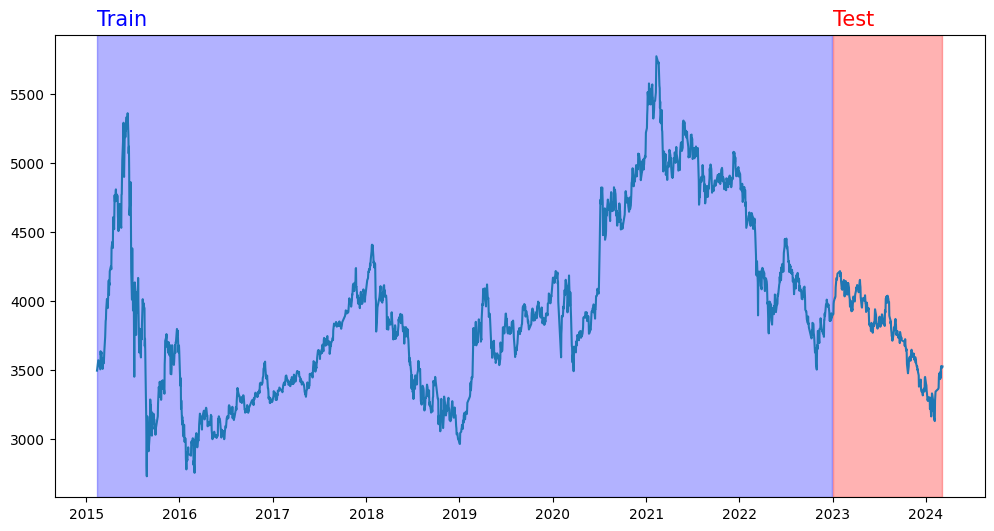

In [3]:
import matplotlib.pyplot as plt

# plot full_data['close']
plt.figure(figsize=(12, 6))
plt.plot(full_data['date'], full_data['close'])

# use different background colors to show train_data, val_data, test_data
plt.axvspan(train_data['date'].iloc[0], train_data['date'].iloc[-1], color='blue', alpha=0.3)
plt.text(train_data['date'].iloc[0], 6000, 'Train', color='blue', fontsize=15)

# plt.axvspan(val_data['date'].iloc[0], val_data['date'].iloc[-1], color='green', alpha=0.3)
# plt.text(val_data['date'].iloc[0], 6000, 'Validation', color='green', fontsize=15)

plt.axvspan(test_data['date'].iloc[0], test_data['date'].iloc[-1], color='red', alpha=0.3)
plt.text(test_data['date'].iloc[0], 6000, 'Test', color='red', fontsize=15)


In [4]:
# use AutoGluon to train a model, predict labels
from autogluon.tabular import TabularPredictor

label = 'label'

predictor = TabularPredictor(label=label)
predictor.fit(full_data.loc[full_data['date'] <= '2022-12-31'], time_limit=600, presets='best_quality')

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels\ag-20240423_124402\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels\ag-20240423_124402\"
AutoGluon Version:  0.8.2
Python Version:     3.10.6
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
Disk Space Avail:   1447.33 GB / 2047.44 GB (70.7%)
Train Data Rows:    1919
Train Data Columns: 20
Label Column: label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == float, but few uniqu

In [5]:
# show AutoGluon leaderboard
# predictor.leaderboard(val_data, silent=True)

In [8]:
import pandas as pd
import numpy as np

principal = 10000000

def trade(principal, data):
    amount_per_trade = principal / 10
    commission = 150
    slippage = 0.2
    contract_size = 300 * 0.12  # 12% of margin ratio
    stop_loss_percentage = 3
    take_profit_percentage = 10

    

    df = data.copy()
    df['label'] = predictor.predict(df)
    # rolling_len = 1
    # df['buy_signal'] = df['label'].rolling(rolling_len).apply(lambda x: (x == 1).sum() >= (int(rolling_len / 2) + 1))
    # df['sell_signal'] = df['label'].rolling(rolling_len).apply(lambda x: (x == -1).sum() >= (int(rolling_len / 2) + 1))

    rolling_len = 3  # 设置滚动窗口长度
    threshold = 1.5  # 设置买入信号阈值
    neg_threshold = -1  # 设置卖出信号阈值

    def weighted_score(x):
        scores = {3: 2, 2: 1, 1: 0.5, -1: -0.5, -2: -1, -3: -2}
        return sum(scores.get(item, 0) for item in x)

    df['score'] = df['label'].rolling(rolling_len, min_periods=1).apply(weighted_score)
    df['buy_signal'] = df['score'] >= threshold
    df['sell_signal'] = df['score'] <= neg_threshold

    trades = []
    remaining_principal = principal
    principal_record = [principal]
    positions = {}
    asset_record = []
    position_record = []

    for index, row in df.iterrows():
        contracts_to_trade = int(amount_per_trade / (row['close'] * contract_size))
        
        current_asset_value = remaining_principal
        for pos_price, pos_contracts in positions.items():
            current_asset_value += pos_contracts * row['close'] * contract_size
        asset_record.append(current_asset_value)
        position_record.append(sum(positions.values()))
        
        # buy
        if row['buy_signal'] and remaining_principal >= amount_per_trade and contracts_to_trade > 0:
            cost = commission + row['close'] * contracts_to_trade * contract_size * (slippage / 100)
            remaining_principal -= contracts_to_trade * row['close'] * contract_size + cost
            if row['close'] in positions:
                positions[row['close']] += contracts_to_trade
            else:
                positions[row['close']] = contracts_to_trade
            trades.append(('buy', row['close'], contracts_to_trade, index))
        
        # take profit & stop loss
        positions_to_remove = []
        for pos_price, pos_contracts in positions.items():
            change_percentage = (row['close'] - pos_price) / pos_price * 100
            if change_percentage <= -stop_loss_percentage or change_percentage >= take_profit_percentage:
                proceeds = pos_contracts * row['close'] * contract_size
                cost = commission + proceeds * (slippage / 100)
                remaining_principal += proceeds - cost
                trades.append(('stop', row['close'], pos_contracts, index, 'loss' if change_percentage <= -stop_loss_percentage else 'profit'))
                positions_to_remove.append(pos_price)
        for price in positions_to_remove:
            del positions[price]

        # sell
        if row['sell_signal']:
            for pos_price, pos_contracts in positions.copy().items():
                if pos_contracts > 0:
                    contracts_to_sell = min(contracts_to_trade, pos_contracts)
                    proceeds = contracts_to_sell * row['close'] * contract_size
                    cost = commission + proceeds * (slippage / 100)
                    remaining_principal += proceeds - cost
                    trades.append(('sell', row['close'], contracts_to_sell, index))
                    positions[pos_price] -= contracts_to_sell 
                    if positions[pos_price] == 0:
                        del positions[pos_price]


        principal_record.append(remaining_principal)


    return trades, remaining_principal, principal_record, sum(positions.values()), asset_record, position_record

trades, remaining_principal, principal_record, positions, asset_record, position_record = trade(principal, test_data)


In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plots(data, trades, asset_record, position_record):
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=data['date'], y=asset_record, mode='lines', name='Total Asset Value', line=dict(color='blue')))
    fig1.update_layout(title='Asset Value Over Time', xaxis_title='Date', yaxis_title='Total Asset Value', template='plotly_white')
    fig1.show()

    fig2 = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig2.add_trace(go.Scatter(x=data['date'], y=data['close'], mode='lines', name='Price', line=dict(color='green')), secondary_y=False)
    
    buy_dates = [data['date'][trade[3]] for trade in trades if trade[0] == 'buy']
    buy_prices = [trade[1] for trade in trades if trade[0] == 'buy']
    sell_dates = [data['date'][trade[3]] for trade in trades if trade[0] == 'sell']
    sell_prices = [trade[1] for trade in trades if trade[0] == 'sell']
    stop_dates = [data['date'][trade[3]] for trade in trades if trade[0] == 'stop']
    stop_prices = [trade[1] for trade in trades if trade[0] == 'stop']
    stop_types = [trade[4] for trade in trades if trade[0] == 'stop']

    fig2.add_trace(go.Scatter(x=buy_dates, y=buy_prices, mode='markers', name='Buy', marker=dict(color='blue', size=10, symbol='triangle-up')), secondary_y=False)
    fig2.add_trace(go.Scatter(x=sell_dates, y=sell_prices, mode='markers', name='Sell', marker=dict(color='red', size=10, symbol='triangle-down')), secondary_y=False)
    fig2.add_trace(go.Scatter(x=stop_dates, y=stop_prices, mode='markers', name='Stop Loss/Take Profit', 
                              marker=dict(color=['orange' if typ == 'profit' else 'grey' for typ in stop_types], size=10, symbol='x')), secondary_y=False)
    
    fig2.add_trace(go.Scatter(x=data['date'], y=position_record, mode='lines', name='Position Record', line=dict(color='purple'), opacity=0.3), secondary_y=True)


    fig2.update_layout(title='Stock Price and Position Record Over Time', xaxis_title='Date', template='plotly_white')
    fig2.update_yaxes(title_text='Price', secondary_y=False)
    fig2.update_yaxes(title_text='Position Record', secondary_y=True)

    fig2.show()
plots(test_data, trades, asset_record, position_record)